In [639]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pandas.api.types import CategoricalDtype




In [640]:
# Cargar el dataset
data = pd.read_csv("train.csv")
data_Test = pd.read_csv("test.csv")

In [641]:
df = data.copy()
df_Test = data_Test.copy()

# Eliminar columnas irrelevantes
df.drop(["id", "laptop_ID", "Product","Price_euros"], axis=1, inplace=True)
df_Test.drop(["id","laptop_ID", "Product"], axis=1, inplace=True)

In [642]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight'],
      dtype='object')

In [643]:
# Información general
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   TypeName          912 non-null    object 
 2   Inches            912 non-null    float64
 3   ScreenResolution  912 non-null    object 
 4   Cpu               912 non-null    object 
 5   Ram               912 non-null    object 
 6   Memory            912 non-null    object 
 7   Gpu               912 non-null    object 
 8   OpSys             912 non-null    object 
 9   Weight            912 non-null    object 
dtypes: float64(1), object(9)
memory usage: 71.4+ KB
None


In [644]:
# Estadísticas descriptivas
print(df.describe())

           Inches
count  912.000000
mean    15.011404
std      1.411744
min     10.100000
25%     14.000000
50%     15.600000
75%     15.600000
max     18.400000


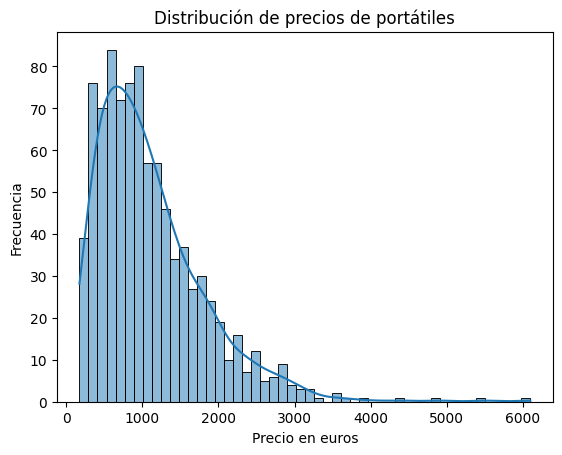

In [645]:
# Histograma de precios
sns.histplot(data["Price_euros"], bins=50, kde=True)
plt.xlabel("Precio en euros")
plt.ylabel("Frecuencia")
plt.title("Distribución de precios de portátiles")
plt.show()


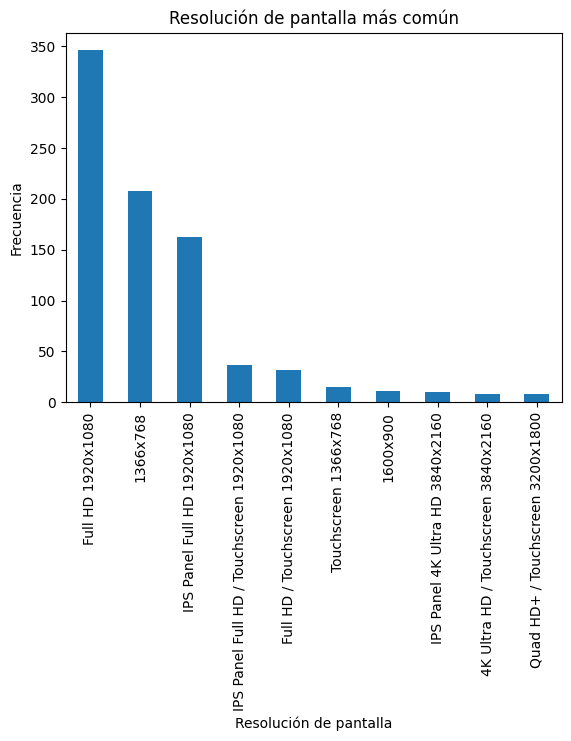

In [646]:
df["ScreenResolution"].value_counts().head(10).plot(kind='bar')
plt.xlabel("Resolución de pantalla")    
plt.ylabel("Frecuencia")
plt.title("Resolución de pantalla más común")
plt.show()
# Gráfico de barras de marcas más comunes

# EVALUACIÓN DEL DATASET:
De acuerdo a lo observado, gran parte de las variables son de tipo object, lo que nos motiva a evaluar el dataset y considerar transformar, de acuerdo a su naturaleza, las variables que sean susceptibles de ser transformadas en numéricas.

In [647]:
# Entre las variables que intentaremos trasnformar están:
# Weight, Ram, y Memory

# Convertir 'Ram' a número
df["Ram"] = df["Ram"].str.replace("GB", "").astype(int)
df_Test["Ram"] = df_Test["Ram"].str.replace("GB", "").astype(int)

# Convertir 'Weight' a número
df["Weight"] = df["Weight"].str.replace("kg", "").astype(float)
df_Test["Weight"] = df_Test["Weight"].str.replace("kg", "").astype(float)



In [648]:
import re
# Procesamos la columna 'Memory'
def split_memory(mem):
    mem = mem.replace("Flash Storage", "Flash_Storage")
    parts = mem.split("+")
    result = {"HDD": 0, "SSD": 0, "Hybrid": 0, "Flash_Storage": 0}

    for part in parts:
        part = part.strip()

        # Buscar el tamaño y tipo con regex
        size_match = re.search(r"(\\d+(\\.\\d+)?)(GB|TB)", part)
        if not size_match:
            continue  # omitir partes no reconocibles

        size = float(size_match.group(1))
        unit = size_match.group(3)
        if unit == "TB":
            size *= 1024  # convertir a GB

        if "HDD" in part:
            result["HDD"] += size
        elif "SSD" in part:
            result["SSD"] += size
        elif "Hybrid" in part:
            result["Hybrid"] += size
        elif "Flash_Storage" in part:
            result["Flash_Storage"] += size

    return pd.Series(result)

df = pd.concat([df, df["Memory"].apply(split_memory)], axis=1)
df.drop("Memory", axis=1, inplace=True)

df_Test = pd.concat([df_Test, df_Test["Memory"].apply(split_memory)], axis=1)
df_Test.drop("Memory", axis=1, inplace=True)


In [649]:
# Procesar la columna 'ScreenResolution' 
# Convertimos en Binaria (dummy) las resoluciones de pantalla especiales
df["Touchscreen"] = df["ScreenResolution"].str.contains("Touchscreen").astype(int)
df["IPS"] = df["ScreenResolution"].str.contains("IPS").astype(int)

df_Test["Touchscreen"] = df_Test["ScreenResolution"].str.contains("Touchscreen").astype(int)
df_Test["IPS"] = df_Test["ScreenResolution"].str.contains("IPS").astype(int)

# Extraer resolución numérica
def extract_resolution(res):
    if pd.isnull(res):
        return pd.Series({"X_res": None, "Y_res": None})
    match = re.search(r"(\d+)x(\d+)", str(res))
    if match:
        return pd.Series({"X_res": int(match.group(1)), "Y_res": int(match.group(2))})
    else:
        return pd.Series({"X_res": None, "Y_res": None})

df = pd.concat([df, df["ScreenResolution"].apply(extract_resolution)], axis=1)
df_Test = pd.concat([df_Test, df_Test["ScreenResolution"].apply(extract_resolution)], axis=1)

# Crear variable ordinal ScreenQuality
def categorize_screen_quality(row):
    x = row["X_res"]
    y = row["Y_res"]
    if pd.isnull(x) or pd.isnull(y):
        return "Unknown"
    elif x < 1280 or y < 800:
        return "Low"
    elif x <= 1920 and y <= 1080:
        return "Full HD"
    elif x <= 2560 and y <= 1600:
        return "2K"
    elif x >= 3840 and y >= 2160:
        return "4K"
    else:
        return "Full HD"

df["ScreenQuality"] = df.apply(categorize_screen_quality, axis=1)
df_Test["ScreenQuality"] = df_Test.apply(categorize_screen_quality, axis=1)


# Convertir a ordinal con categorías ordenadas
from pandas.api.types import CategoricalDtype
quality_order = CategoricalDtype(categories=["Low","Full HD", "2K", "4K"], ordered=True)
df["ScreenQuality"] = df["ScreenQuality"].astype(quality_order)
df_Test["ScreenQuality"] = df_Test["ScreenQuality"].astype(quality_order)

# Codificar ordinalmente como entero (opcional)
#df["ScreenQuality_Ordinal"] = df["ScreenQuality"].cat.codes

# Finalmente eliminamos columnas que ya no se necesiten
df.drop(["ScreenResolution", "X_res", "Y_res"], axis=1, inplace=True)
df_Test.drop(["ScreenResolution", "X_res", "Y_res"], axis=1, inplace=True)

<Axes: xlabel='ScreenQuality'>

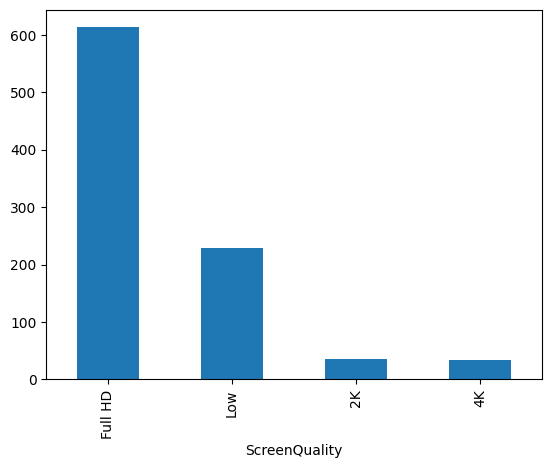

In [650]:
df.ScreenQuality.value_counts().plot(kind='bar')
df_Test.ScreenQuality.value_counts().plot(kind='bar')

In [651]:
print(df["ScreenQuality"].value_counts(dropna=False))

ScreenQuality
Full HD    613
Low        229
2K          36
4K          34
Name: count, dtype: int64


In [652]:
def extract_cpu_speed(cpu_str):
    match = re.search(r"(\d+[.,]?\d*)GHz", cpu_str)
    if match:
        return float(match.group(1).replace(",", "."))
    else:
        return np.nan

df["Cpu_speed_GHz"] = df["Cpu"].apply(extract_cpu_speed)
df_Test["Cpu_speed_GHz"] = df_Test["Cpu"].apply(extract_cpu_speed)

In [653]:
# Procesar la columna 'Cpu'
df["Cpu_brand"] = df["Cpu"].apply(lambda x: x.split()[0])
df["Cpu_model"] = df["Cpu"].apply(lambda x: " ".join(x.split()[1:3]))
df.drop("Cpu", axis=1, inplace=True)

df_Test["Cpu_brand"] = df_Test["Cpu"].apply(lambda x: x.split()[0])
df_Test["Cpu_model"] = df_Test["Cpu"].apply(lambda x: " ".join(x.split()[1:3]))
df_Test.drop("Cpu", axis=1, inplace=True)


In [654]:
df["Cpu_speed_GHz"].unique()
df["Cpu_speed_GHz"].info()

df_Test["Cpu_speed_GHz"].unique()
df_Test["Cpu_speed_GHz"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 912 entries, 0 to 911
Series name: Cpu_speed_GHz
Non-Null Count  Dtype  
--------------  -----  
912 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB
<class 'pandas.core.series.Series'>
RangeIndex: 391 entries, 0 to 390
Series name: Cpu_speed_GHz
Non-Null Count  Dtype  
--------------  -----  
391 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [655]:
# Procesar la columna 'Gpu'
df["Gpu_brand"] = df["Gpu"].apply(lambda x: x.split()[0])
df.drop("Gpu", axis=1, inplace=True)

df_Test["Gpu_brand"] = df_Test["Gpu"].apply(lambda x: x.split()[0])
df_Test.drop("Gpu", axis=1, inplace=True)


In [694]:
print(df.columns)
print(df_Test.columns)

Index(['Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'HDD', 'SSD',
       'Hybrid', 'Flash_Storage', 'Touchscreen', 'IPS', 'ScreenQuality',
       'Cpu_speed_GHz', 'Cpu_brand', 'Cpu_model', 'Gpu_brand'],
      dtype='object')
Index(['Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'HDD', 'SSD',
       'Hybrid', 'Flash_Storage', 'Touchscreen', 'IPS', 'ScreenQuality',
       'Cpu_speed_GHz', 'Cpu_brand', 'Cpu_model', 'Gpu_brand'],
      dtype='object')


In [695]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Company        912 non-null    object  
 1   TypeName       912 non-null    object  
 2   Inches         912 non-null    float64 
 3   Ram            912 non-null    int64   
 4   OpSys          912 non-null    object  
 5   Weight         912 non-null    float64 
 6   HDD            912 non-null    int64   
 7   SSD            912 non-null    int64   
 8   Hybrid         912 non-null    int64   
 9   Flash_Storage  912 non-null    int64   
 10  Touchscreen    912 non-null    int64   
 11  IPS            912 non-null    int64   
 12  ScreenQuality  912 non-null    category
 13  Cpu_speed_GHz  912 non-null    float64 
 14  Cpu_brand      912 non-null    object  
 15  Cpu_model      912 non-null    object  
 16  Gpu_brand      912 non-null    object  
dtypes: category(1), float64(3), int64(7

In [696]:
# # Codificar variables categóricas
# categorical_cols = ["Company", "TypeName", "OpSys", "Cpu_brand", "Cpu_model", "Gpu_brand","ScreenQuality"]
# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [697]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'HDD', 'SSD',
       'Hybrid', 'Flash_Storage', 'Touchscreen', 'IPS', 'ScreenQuality',
       'Cpu_speed_GHz', 'Cpu_brand', 'Cpu_model', 'Gpu_brand'],
      dtype='object')

In [698]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from pandas.api.types import CategoricalDtype

In [705]:
numerical_features = ["Inches", "Ram", "Weight", "Touchscreen", "IPS", "Cpu_speed_GHz"]
categorical_features = ["Company", "TypeName", "OpSys", "Cpu_brand", "Cpu_model", "Gpu_brand","ScreenQuality"]

# =====================
# 4. Definir preprocesamiento
# =====================
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# =====================
# 5. Separar datos y dividir
# =====================
X = df[numerical_features + categorical_features]
y = data['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# =====================
# 6. Definir modelos
# =====================
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5),
    "LassoCV": LassoCV(alphas=np.logspace(-3, 3, 50), cv=5),
    "ElasticNetCV": ElasticNetCV(l1_ratio=[.1, .5, .9, .95, .99, 1], cv=5),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, verbosity=0, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
}

# =====================
# 7. Ajustar y evaluar modelos
# =====================
results = []
pred_modelos ={}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("regressor", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    y_pred_Test = pipe.predict(df_Test[numerical_features + categorical_features])
    pred_modelos[name] = y_pred_Test
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MAE_train":mae_train,"MAE":mae,"%MAE":mape,"RMSE": rmse, "R2": r2, "y_pred_Test": y_pred_Test})
    print(f"{name:20} MAE_train: {mae_train:.2f} | MAE: {mae:.2f}|MAPE: {mape:.2f}| RMSE: {rmse:.2f} | R2: {r2:.4f}")

# =====================
# 8. Comparativa final
# =====================
results_df = pd.DataFrame(results).sort_values(by="MAE")

print("\nComparación de Modelos:")
print(results_df)

LinearRegression     MAE_train: 222.26 | MAE: 222.02|MAPE: 0.25| RMSE: 317.80 | R2: 0.7662
RidgeCV              MAE_train: 233.58 | MAE: 223.40|MAPE: 0.24| RMSE: 312.39 | R2: 0.7741
LassoCV              MAE_train: 240.97 | MAE: 224.89|MAPE: 0.24| RMSE: 325.27 | R2: 0.7550
ElasticNetCV         MAE_train: 237.26 | MAE: 225.39|MAPE: 0.25| RMSE: 314.54 | R2: 0.7709
GradientBoosting     MAE_train: 95.96 | MAE: 180.29|MAPE: 0.18| RMSE: 300.03 | R2: 0.7916
XGBoost              MAE_train: 102.30 | MAE: 188.50|MAPE: 0.19| RMSE: 306.13 | R2: 0.7830
RandomForest         MAE_train: 114.14 | MAE: 196.02|MAPE: 0.20| RMSE: 327.94 | R2: 0.7510

Comparación de Modelos:
              Model   MAE_train         MAE      %MAE        RMSE        R2  \
4  GradientBoosting   95.959962  180.286876  0.183002  300.028536  0.791582   
5           XGBoost  102.304264  188.500093  0.194307  306.133376  0.783014   
6      RandomForest  114.137733  196.020829  0.197028  327.939796  0.751000   
0  LinearRegression  22

In [706]:
results_df_predict = results_df[["Model", "y_pred_Test"]].set_index("Model")
results_df_predict.to_csv("Pipeline_predicciones_modelos.csv")
results_df_predict

,y_pred_Test
Model,
GradientBoosting,"[1957.8026294338667, 478.2333013933397, 353.40..."
XGBoost,"[1943.8374, 495.54822, 356.36713, 1469.3668, 1..."
RandomForest,"[2212.606869207617, 609.069510316877, 424.6075..."
LinearRegression,"[2588.289524498357, 297.44483465147755, 290.77..."
RidgeCV,"[2661.9380910471627, 413.4794831486706, 302.20..."
LassoCV,"[2602.6366053993847, 600.738840123432, 355.343..."
ElasticNetCV,"[2642.8572143090805, 476.639907659707, 316.528..."


In [707]:
# =====================
# Guardar mejor modelo 
# =====================
import joblib
best_model = results_df.iloc[0]["Model"]
print(f"Mejor modelo: {best_model}, MAE: {results_df.iloc[0]['MAE']:.2f}")
joblib.dump(models[best_model], "best_model.pkl")


Mejor modelo: GradientBoosting, MAE: 180.29


['best_model.pkl']

In [708]:

pd_join = pd.DataFrame({'id': data_Test['id'], 'Price_euros': results_df.iloc[0].y_pred_Test})
pd_join.to_csv('Pipeline_best_predictions.csv', index=False)
pd_join.head()

,id,Price_euros
0,181,1957.802629
1,708,478.233301
2,862,353.407486
3,1064,1447.306859
4,702,1116.163723


In [709]:
pred_modelos["XGBoost"]

array([1943.8374 ,  495.54822,  356.36713, 1469.3668 , 1073.2717 ,
       1452.3726 , 2967.7053 ,  577.08527, 2945.9233 , 1982.9703 ,
       1448.1478 ,  564.6396 ,  321.86786,  538.4069 ,  437.1217 ,
       1492.4182 ,  335.64233, 1981.4575 , 1511.7369 , 1397.5474 ,
       2120.4253 , 1216.3562 , 1583.2455 , 1373.6562 , 1852.9185 ,
        264.43814,  896.5822 ,  357.5235 , 1311.7264 ,  474.98495,
        992.32874, 1281.9612 , 1947.5778 ,  538.5916 ,  637.67255,
       1717.9495 ,  848.3221 ,  674.35913, 3228.069  ,  484.5522 ,
        715.0101 ,  987.4808 , 1111.6416 , 2136.286  , 1003.7999 ,
       1788.926  ,  467.57544, 4351.2236 ,  287.57874, 1448.1478 ,
       1062.3784 ,  996.92755,  950.96735,  339.4718 , 1145.2081 ,
        677.2954 , 1090.0442 ,  265.11374, 1411.3696 , 1122.7898 ,
       1511.0057 , 1353.2334 ,  538.5125 , 1254.0874 , 1196.6215 ,
       1469.5013 ,  586.9548 , 2508.2957 ,  679.1    , 1941.2614 ,
        936.3286 , 3138.7822 , 2038.281  , 1140.63   , 1265.58